In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import cv2
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, log_loss, confusion_matrix, matthews_corrcoef, accuracy_score, roc_curve, roc_auc_score, jaccard_score, rand_score, auc
import xgboost as xgb
import lime
import shap
import lime.lime_tabular
import eli5

In [2]:

ORANGE = '#ff7f0e'
BLUE = '#1f77b4'

custom_palette = [BLUE, ORANGE]
sns.set_palette(custom_palette)

custom_cmap = ListedColormap(custom_palette)
corr_cmap = LinearSegmentedColormap.from_list("custom_cmap", [BLUE, ORANGE])

In [3]:

def balance_and_undersample(X, y):
    pos_count = np.sum(y == 1)
    neg_count = np.sum(y == 0)
    
    X_pos = X[y == 1]
    X_neg = X[y == 0]
    
    X_neg_sampled = shuffle(X_neg, random_state=0).iloc[:pos_count]
    y_neg_sampled = np.zeros(pos_count)
    
    X_balanced = pd.concat([X_pos, X_neg_sampled])
    y_balanced = np.concatenate([np.ones(pos_count), y_neg_sampled])
    
    X_balanced, y_balanced = shuffle(X_balanced, y_balanced, random_state=0)
    
    return X_balanced, y_balanced


In [4]:
roc_auc_values = []

In [5]:
def compute_metrics(model, X_train, X_test, y_train, y_test, model_name, idx, k=None):

    model.fit(X_train_selected, y_train)
    
    y_train_pred = model.predict(X_train_selected)
    y_test_pred = model.predict(X_test_selected)
    y_test_proba = model.predict_proba(X_test_selected)
    
    if y_test_proba.shape[1] == 2:
        y_test_proba = y_test_proba[:, 1]
    else:
        raise ValueError("Expected binary classification with 2 probability columns.")
    
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    roc_auc = roc_auc_score(y_test, y_test_proba)
    
    roc_auc_values.append((model_name, roc_auc))
    
    report = classification_report(y_test, y_test_pred, output_dict=True, zero_division=1)
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    
    if conf_matrix.shape == (2, 2):
        TN, FP, FN, TP = conf_matrix.ravel()
    else:
        TN, FP, FN, TP = np.array([0, 0, 0, 0])

    accuracy_train = accuracy_score(y_train, y_train_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    log_loss_value = log_loss(y_test, y_test_proba)
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    mcc = matthews_corrcoef(y_test, y_test_pred)
    jaccard = jaccard_score(y_test, y_test_pred)
    dice_coeff = 2 * TP / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0
    rand_index = rand_score(y_test, y_test_pred)

    print(f"Model {idx}: {model_name}\nSelected Features: {5}")
    print(report)
    
    return pd.DataFrame([{
        'Model': model_name,
        'Training Accuracy': accuracy_train,
        'Testing Accuracy': accuracy_test,
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'F1 Score': f1,
        'AUC': roc_auc,
        'Log Loss': log_loss_value,
        'Jaccard': jaccard,
        'Dice Coefficient': dice_coeff,
        'Rand Index': rand_index,
        'MCC': mcc
    }])


In [6]:
# Set path
dataset_path = '/kaggle/input/alz-dataset/alzheimers_disease_data.csv'
df = pd.read_csv(dataset_path)

In [7]:
df.head()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


In [8]:
# Non-binary Features : Age, EducationLevel, BMI, AlcoholConsumption, PhysicalActivity, DietQuality, ADL
# Ethnicity
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  2149 non-null   int64  
 1   Age                        2149 non-null   int64  
 2   Gender                     2149 non-null   int64  
 3   Ethnicity                  2149 non-null   int64  
 4   EducationLevel             2149 non-null   int64  
 5   BMI                        2149 non-null   float64
 6   Smoking                    2149 non-null   int64  
 7   AlcoholConsumption         2149 non-null   float64
 8   PhysicalActivity           2149 non-null   float64
 9   DietQuality                2149 non-null   float64
 10  SleepQuality               2149 non-null   float64
 11  FamilyHistoryAlzheimers    2149 non-null   int64  
 12  CardiovascularDisease      2149 non-null   int64  
 13  Diabetes                   2149 non-null   int64

In [9]:
# Eliminate 
df = df.drop(columns=['DoctorInCharge'])
df = df.drop(columns=['PatientID'])

In [10]:
df.head()

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,9.025679,...,6.518877,0,0,1.725883,0,0,0,1,0,0
1,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,...,7.118696,0,0,2.592424,0,0,0,0,1,0
2,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,...,5.895077,0,0,7.119548,0,1,0,1,0,0
3,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,...,8.965106,0,1,6.481226,0,0,0,0,0,0
4,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,...,6.045039,0,0,0.014691,0,0,1,1,0,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        2149 non-null   int64  
 1   Gender                     2149 non-null   int64  
 2   Ethnicity                  2149 non-null   int64  
 3   EducationLevel             2149 non-null   int64  
 4   BMI                        2149 non-null   float64
 5   Smoking                    2149 non-null   int64  
 6   AlcoholConsumption         2149 non-null   float64
 7   PhysicalActivity           2149 non-null   float64
 8   DietQuality                2149 non-null   float64
 9   SleepQuality               2149 non-null   float64
 10  FamilyHistoryAlzheimers    2149 non-null   int64  
 11  CardiovascularDisease      2149 non-null   int64  
 12  Diabetes                   2149 non-null   int64  
 13  Depression                 2149 non-null   int64

In [12]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,2149.0,74.908795,8.990221,60.000000,67.000000,75.000000,83.000000,90.000000
Gender,2149.0,0.506282,0.500077,0.000000,0.000000,1.000000,1.000000,1.000000
Ethnicity,2149.0,0.697534,0.996128,0.000000,0.000000,0.000000,1.000000,3.000000
EducationLevel,2149.0,1.286645,0.904527,0.000000,1.000000,1.000000,2.000000,3.000000
BMI,2149.0,27.655697,7.217438,15.008851,21.611408,27.823924,33.869778,39.992767
Smoking,2149.0,0.288506,0.453173,0.000000,0.000000,0.000000,1.000000,1.000000
AlcoholConsumption,2149.0,10.039442,5.757910,0.002003,5.139810,9.934412,15.157931,19.989293
PhysicalActivity,2149.0,4.920202,2.857191,0.003616,2.570626,4.766424,7.427899,9.987429
DietQuality,2149.0,4.993138,2.909055,0.009385,2.458455,5.076087,7.558625,9.998346
SleepQuality,2149.0,7.051081,1.763573,4.002629,5.482997,7.115646,8.562521,9.999840


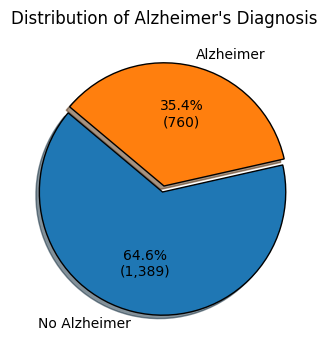

In [13]:
diagnosis_counts = df['Diagnosis'].value_counts()

labels = ['No Alzheimer', 'Alzheimer']

colors = [BLUE, ORANGE]

plt.figure(figsize=(4, 4)) 
plt.pie(diagnosis_counts, labels=labels, colors=colors, 
        autopct=lambda p: f'{p:.1f}%\n({int(p * sum(diagnosis_counts) / 100):,})', 
        startangle=140, explode=[0.05, 0], shadow=True, 
        wedgeprops={'edgecolor': 'black'})

plt.title("Distribution of Alzheimer's Diagnosis")
plt.savefig('Dis_Original.png', dpi=600, bbox_inches='tight')
plt.show()

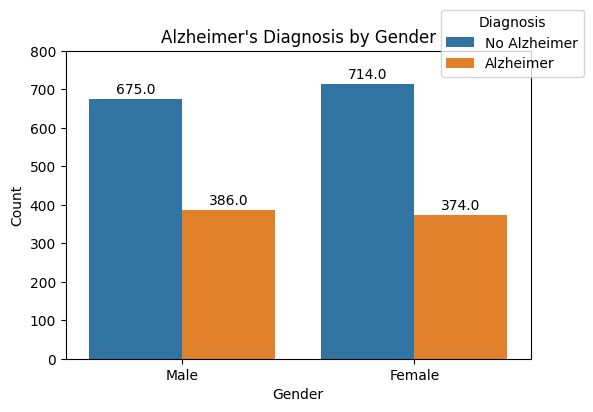

In [14]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='Gender', hue='Diagnosis', data=df, palette=custom_palette)
plt.ylim([0, 800])
plt.title("Alzheimer's Diagnosis by Gender")
plt.xlabel('Gender')
plt.ylabel('Count')

plt.xticks([0, 1], ['Male', 'Female'])

handles, labels = ax.get_legend_handles_labels()
# plt.legend(handles, ['No Alzheimer', 'Alzheimer'], title='Diagnosis')
# Flag
ax.legend_.remove()
plt.figlegend(handles, ['No Alzheimer', 'Alzheimer'], loc='upper right', bbox_to_anchor=(1, 1), ncol=1, title='Diagnosis')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 4), 
                textcoords='offset points')
# plt.tight_layout(rect=[0, 0, 0.85, 0.95])  
plt.grid(False)
plt.savefig("Gender_CountPlot.jpg", dpi=600)
plt.show()
plt.close()

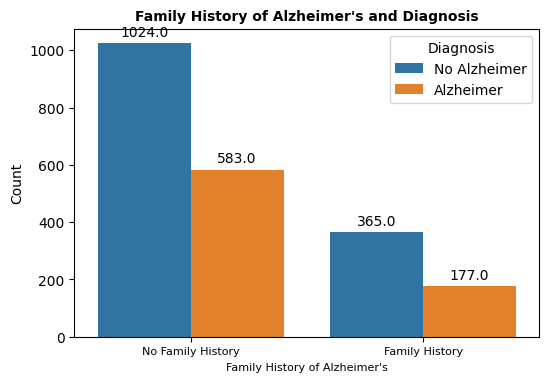

In [15]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='FamilyHistoryAlzheimers', hue='Diagnosis', data=df, palette=custom_palette)

plt.title("Family History of Alzheimer's and Diagnosis", fontsize=10, fontweight='bold')
plt.xlabel('Family History of Alzheimer\'s', fontsize=8)
plt.ylabel('Count', fontsize=10)

plt.xticks([0, 1], ['No Family History', 'Family History'], fontsize=8)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, ['No Alzheimer', 'Alzheimer'], title='Diagnosis')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.grid(False)
plt.savefig("count1.jpg", dpi=600)
plt.show()


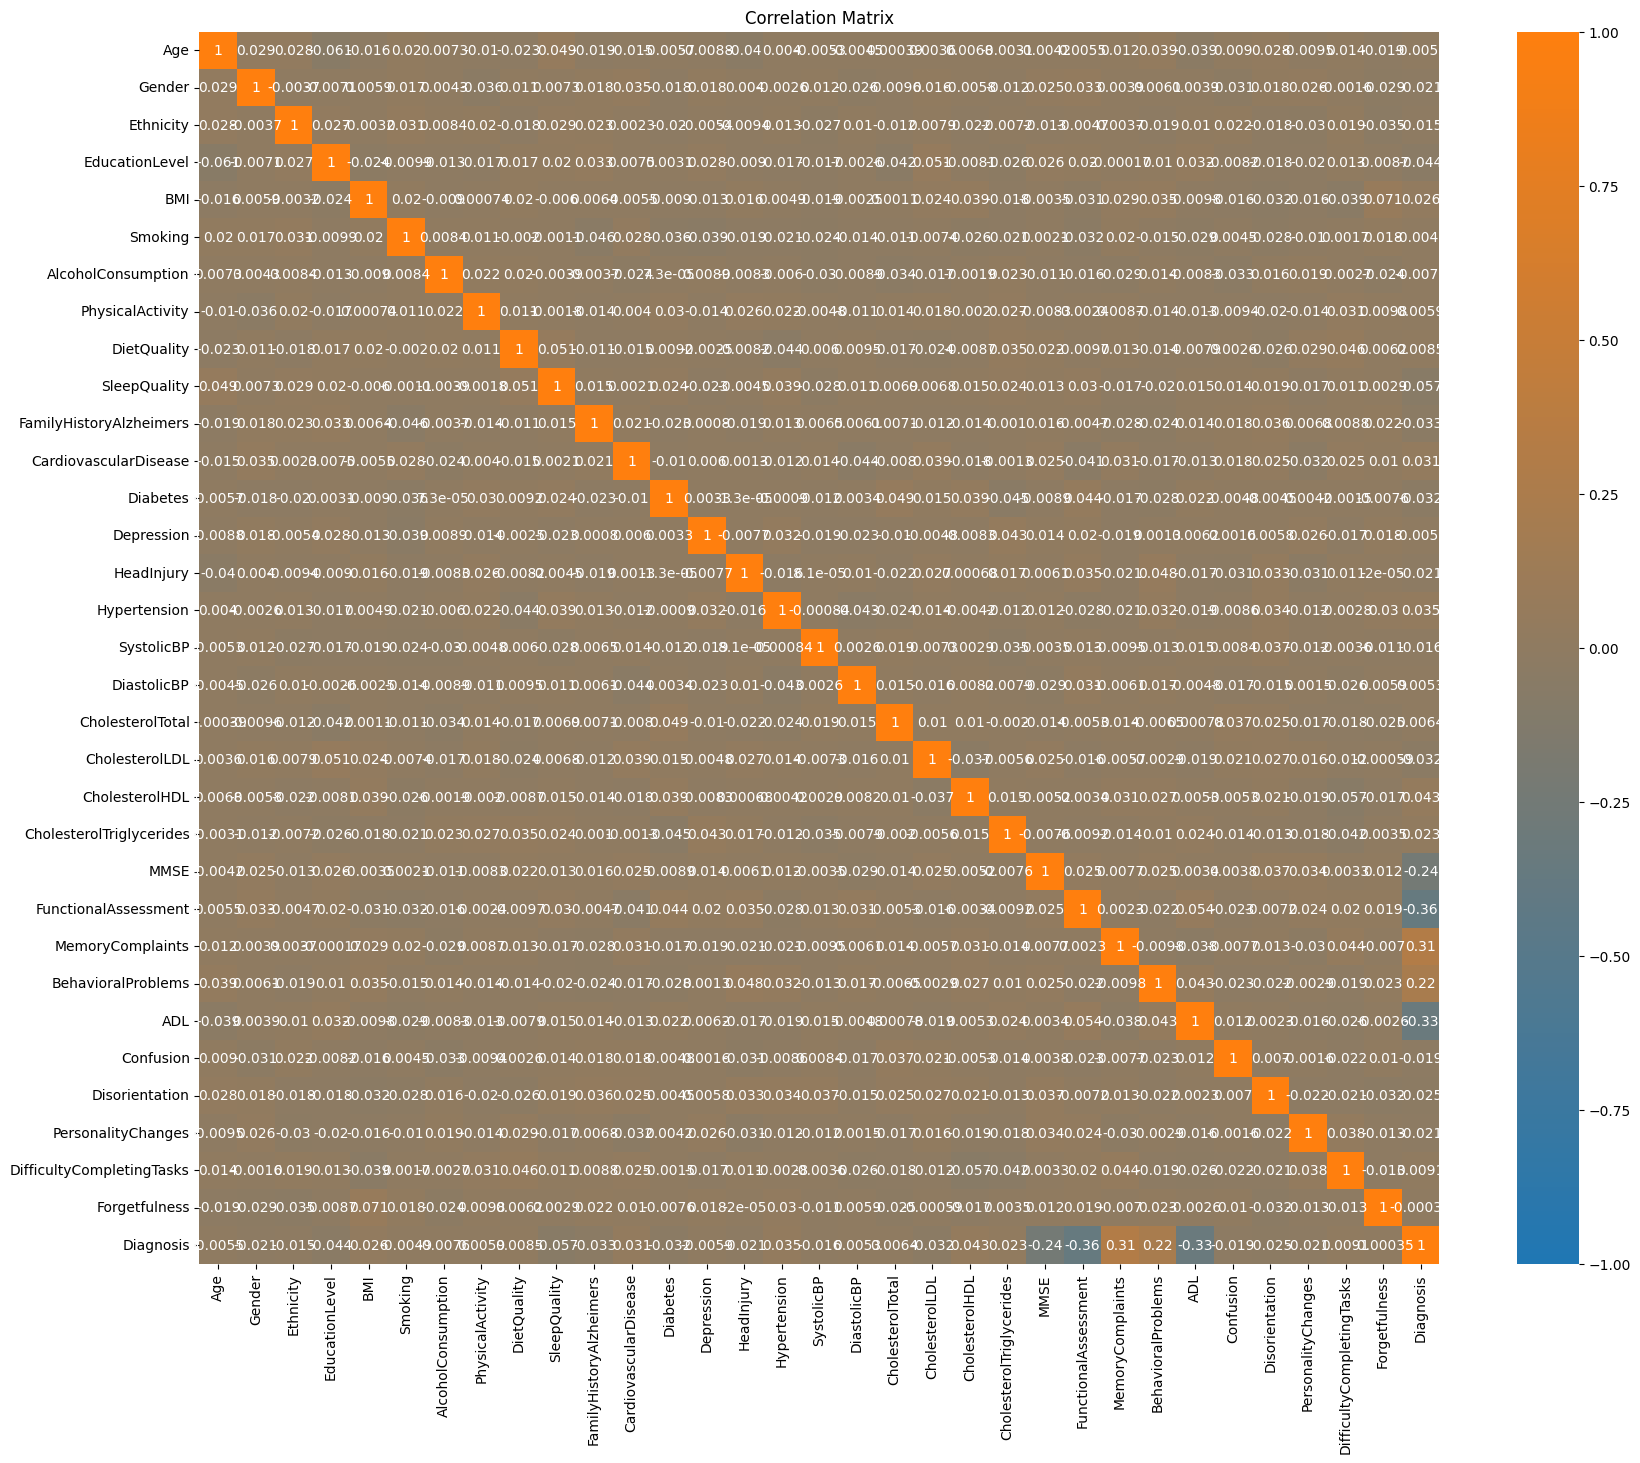

In [16]:
# Duplicate dataframe
df_dup = df.copy()

# Correlation Matrix
correlation_matrix = df.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap=corr_cmap, vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.savefig('/kaggle/working/correlation_matrix.png', dpi=600, bbox_inches='tight')
plt.show()


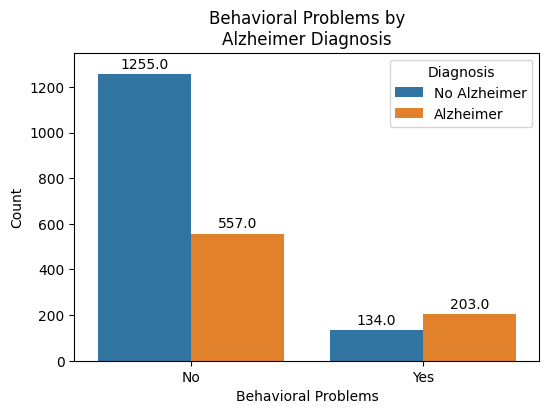

In [17]:
# Countplot based on BehavioralProblems

plt.figure(figsize=(6, 4))
ax = sns.countplot(x='BehavioralProblems', hue='Diagnosis', data=df, palette=custom_palette)
ax.set_xticklabels(['No', 'Yes'])
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='baseline',
                xytext=(0, 4), 
                textcoords='offset points')
plt.title('Behavioral Problems by\nAlzheimer Diagnosis')
plt.ylim([0, 1350])
plt.xlabel('Behavioral Problems')
plt.ylabel('Count')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['No Alzheimer', 'Alzheimer'], title='Diagnosis')
plt.savefig('BehavioralProblems_CountPlot.png', dpi=600, bbox_inches='tight')
plt.show()


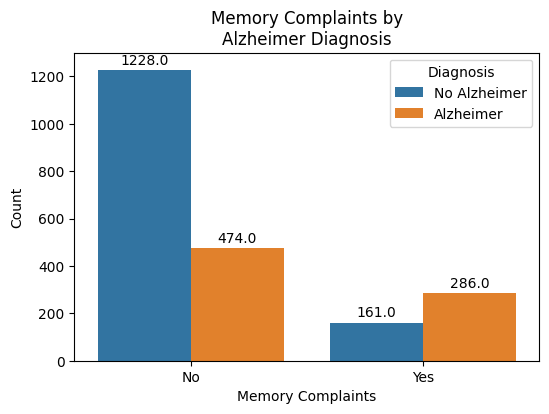

In [18]:
# Countplot based on MemoryComplaints

plt.figure(figsize=(6, 4))
ax = sns.countplot(x='MemoryComplaints', hue='Diagnosis', data=df, palette=custom_palette)
ax.set_xticklabels(['No', 'Yes'])
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='baseline',
                xytext=(0, 4), 
                textcoords='offset points')
plt.title('Memory Complaints by\nAlzheimer Diagnosis')
plt.ylim([0, 1300])
plt.xlabel('Memory Complaints')
plt.ylabel('Count')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['No Alzheimer', 'Alzheimer'], title='Diagnosis')
plt.savefig('MemoryComplaints_CountPlot.png', dpi=600, bbox_inches='tight')
plt.show()


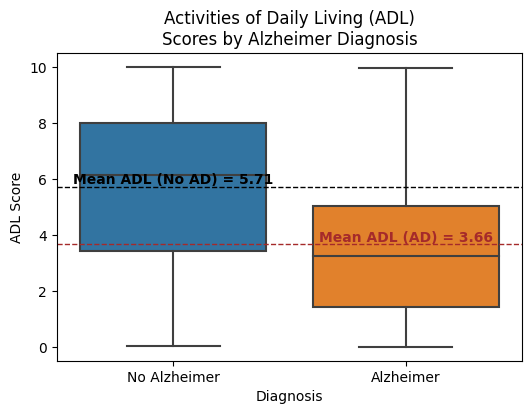

In [20]:
mean_adl_no_ad = df[df['Diagnosis'] == 0]['ADL'].mean()
mean_adl_ad = df[df['Diagnosis'] == 1]['ADL'].mean()

plt.figure(figsize=(6, 4))
ax = sns.boxplot(x='Diagnosis', y='ADL', data=df, palette=custom_palette)
plt.title('Activities of Daily Living (ADL)\nScores by Alzheimer Diagnosis')

ax.axhline(mean_adl_no_ad, linestyle='--', color='black', linewidth=1, label='Mean ADL (No AD)')
ax.axhline(mean_adl_ad, linestyle='--', color='brown', linewidth=1, label='Mean ADL (AD)')

ax.text(0, mean_adl_no_ad, f'Mean ADL (No AD) = {mean_adl_no_ad:.2f}', color='black', ha='center', va='bottom', fontsize=10, weight='bold')
ax.text(1, mean_adl_ad, f'Mean ADL (AD) = {mean_adl_ad:.2f}', color='brown', ha='center', va='bottom', fontsize=10, weight='bold')

ax.set_xticklabels(['No Alzheimer', 'Alzheimer'])
plt.xlabel('Diagnosis')
plt.ylabel('ADL Score')

# plt.legend(title='Legends', loc='upper right')
plt.savefig('ADL_BoxPlot.png', dpi=600, bbox_inches='tight')
plt.show()

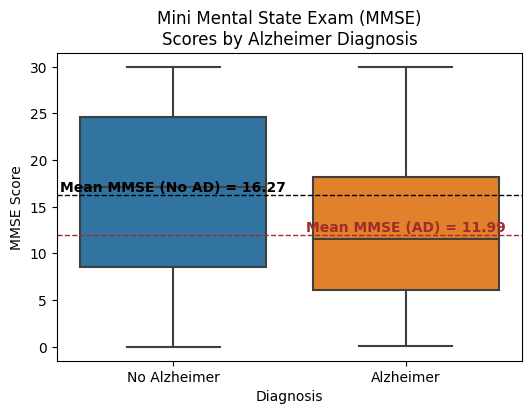

In [22]:
mean_mmse_no_ad = df[df['Diagnosis'] == 0]['MMSE'].mean()
mean_mmse_ad = df[df['Diagnosis'] == 1]['MMSE'].mean()
# mean_mmse = df['MMSE'].mean()

plt.figure(figsize=(6, 4))
ax = sns.boxplot(x='Diagnosis', y='MMSE', data=df, palette=custom_palette)
plt.title('Mini Mental State Exam (MMSE)\nScores by Alzheimer Diagnosis')

ax.axhline(mean_mmse_no_ad, linestyle='--', color='black', linewidth=1, label='Mean MMSE (No AD)')
ax.axhline(mean_mmse_ad, linestyle='--', color='brown', linewidth=1, label='Mean MMSE (AD)')

ax.text(0, mean_mmse_no_ad, f'Mean MMSE (No AD) = {mean_mmse_no_ad:.2f}', color='black', ha='center', va='bottom', fontsize=10, weight='bold')
ax.text(1, mean_mmse_ad, f'Mean MMSE (AD) = {mean_mmse_ad:.2f}', color='brown', ha='center', va='bottom', fontsize=10, weight='bold')

ax.set_xticklabels(['No Alzheimer', 'Alzheimer'])
plt.xlabel('Diagnosis')
plt.ylabel('MMSE Score')

# plt.legend(title='Legends', loc='upper right')
plt.savefig('MMSE_BoxPlot.png', dpi=600, bbox_inches='tight')
plt.show()

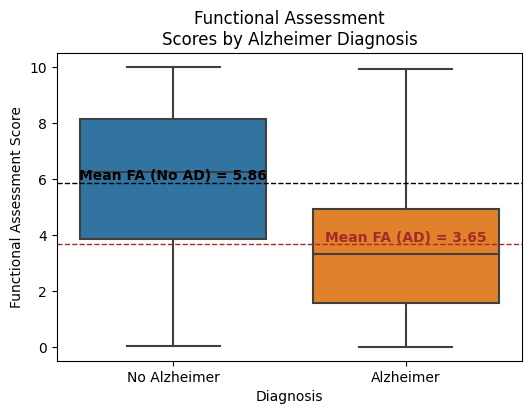

In [24]:
mean_fa_no_ad = df[df['Diagnosis'] == 0]['FunctionalAssessment'].mean()
mean_fa_ad = df[df['Diagnosis'] == 1]['FunctionalAssessment'].mean()

plt.figure(figsize=(6, 4))
ax = sns.boxplot(x='Diagnosis', y='FunctionalAssessment', data=df, palette=custom_palette)
plt.title('Functional Assessment\nScores by Alzheimer Diagnosis')

ax.axhline(mean_fa_no_ad, linestyle='--', color='black', linewidth=1, label='Mean FA (No AD)')
ax.axhline(mean_fa_ad, linestyle='--', color='brown', linewidth=1, label='Mean FA (AD)')

ax.text(0, mean_fa_no_ad, f'Mean FA (No AD) = {mean_fa_no_ad:.2f}', color='black', ha='center', va='bottom', fontsize=10, weight='bold')
ax.text(1, mean_fa_ad, f'Mean FA (AD) = {mean_fa_ad:.2f}', color='brown', ha='center', va='bottom', fontsize=10, weight='bold')

ax.set_xticklabels(['No Alzheimer', 'Alzheimer'])
plt.xlabel('Diagnosis')
plt.ylabel('Functional Assessment Score')

# plt.legend(title='Legends', loc='upper right')
plt.savefig('FunctionalAssessment_BoxPlot.png', dpi=600, bbox_inches='tight')
plt.show()

In [57]:
# Lifestyle Features
df_melt = pd.melt(df, id_vars=['Diagnosis'], value_vars=['BMI', 'PhysicalActivity', 'AlcoholConsumption', 'DietQuality', 'SleepQuality'],
                  var_name='Feature', value_name='Value')
df_melt['Feature'] = df_melt['Feature'].replace({
    'BMI': 'BMI',
    'PhysicalActivity': 'Physical\nActivity',
    'AlcoholConsumption': 'Alcohol\nConsumption',
    'DietQuality': 'Diet\nQuality',
    'SleepQuality': 'Sleep\nQuality'
})
df_melt['Diagnosis'] = df_melt['Diagnosis'].replace({0: 'No AD', 1: 'AD'})

plt.figure(figsize=(6, 4))
sns.boxplot(x='Feature', y='Value', hue='Diagnosis', data=df_melt)

plt.title(f"Lifestyle Features\nfor Alzheimer's vs No Alzheimer's")
plt.xlabel('Feature')
plt.ylabel('Value')

plt.savefig('/kaggle/working/LifestyleFeatures_BoxPlot.png', dpi=600)
plt.show()


SyntaxError: invalid syntax. Perhaps you forgot a comma? (1233626118.py, line 16)

In [26]:
# Symptoms

# Forgetfulness, Confusion, DifficultyCompletingTasks, Disorientation, PersonalityChanges

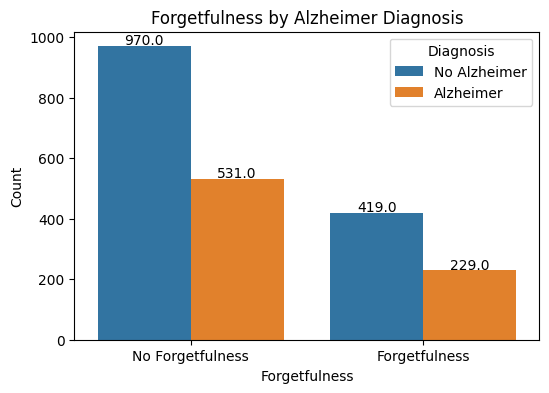

In [27]:
# Countplot based on Forgetfulness

plt.figure(figsize=(6, 4))
ax = sns.countplot(x='Forgetfulness', hue='Diagnosis', data=df, palette=custom_palette)
ax.set_xticklabels(['No Forgetfulness', 'Forgetfulness'])
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center',
                xytext=(0, 4), 
                textcoords='offset points')
plt.title('Forgetfulness by Alzheimer Diagnosis')
plt.xlabel('Forgetfulness')
plt.ylabel('Count')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['No Alzheimer', 'Alzheimer'], title='Diagnosis')
plt.savefig('Forgetfulness_CountPlot.png', dpi=600, bbox_inches='tight')
plt.show()


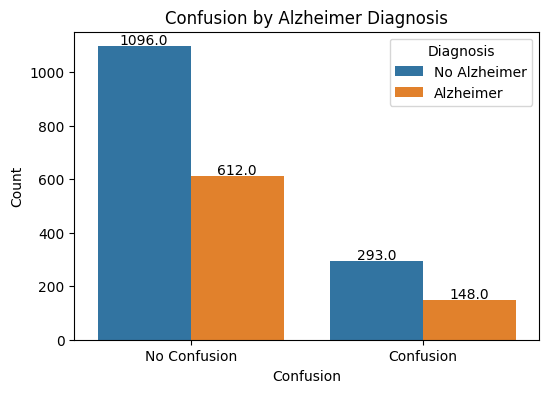

In [28]:
# Countplot based on Confusion

plt.figure(figsize=(6, 4))
ax = sns.countplot(x='Confusion', hue='Diagnosis', data=df, palette=custom_palette)
ax.set_xticklabels(['No Confusion', 'Confusion'])
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center',
                xytext=(0, 4), 
                textcoords='offset points')
plt.title('Confusion by Alzheimer Diagnosis')
plt.xlabel('Confusion')
plt.ylabel('Count')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['No Alzheimer', 'Alzheimer'], title='Diagnosis')
plt.savefig('Confusion_CountPlot.png', dpi=600, bbox_inches='tight')
plt.show()


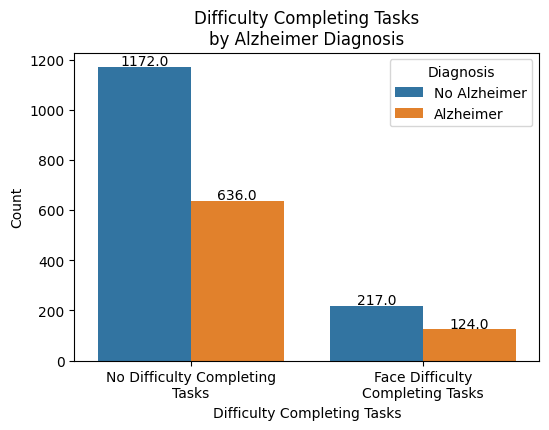

In [29]:
# Countplot based on DifficultyCompletingTasks

plt.figure(figsize=(6, 4))
ax = sns.countplot(x='DifficultyCompletingTasks', hue='Diagnosis', data=df, palette=custom_palette)
ax.set_xticklabels(['No Difficulty Completing\nTasks', 'Face Difficulty\nCompleting Tasks'])
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center',
                xytext=(0, 4), 
                textcoords='offset points')
plt.title('Difficulty Completing Tasks\nby Alzheimer Diagnosis')
plt.xlabel('Difficulty Completing Tasks')
plt.ylabel('Count')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['No Alzheimer', 'Alzheimer'], title='Diagnosis')
plt.savefig('DifficultyCompletingTasks_CountPlot.png', dpi=600, bbox_inches='tight')
plt.show()


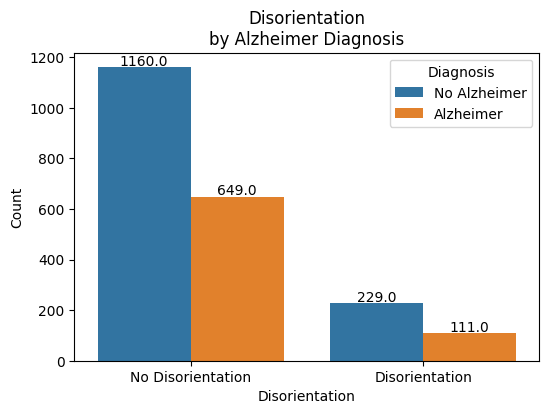

In [30]:
# Countplot based on Disorientation

plt.figure(figsize=(6, 4))
ax = sns.countplot(x='Disorientation', hue='Diagnosis', data=df, palette=custom_palette)
ax.set_xticklabels(['No Disorientation', 'Disorientation'])
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center',
                xytext=(0, 4), 
                textcoords='offset points')
plt.title('Disorientation\nby Alzheimer Diagnosis')
plt.xlabel('Disorientation')
plt.ylabel('Count')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['No Alzheimer', 'Alzheimer'], title='Diagnosis')
plt.savefig('Disorientation_CountPlot.png', dpi=600, bbox_inches='tight')
plt.show()


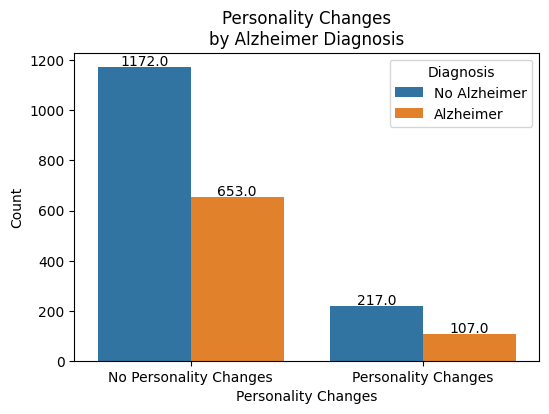

In [31]:
# Countplot based on PersonalityChanges

plt.figure(figsize=(6, 4))
ax = sns.countplot(x='PersonalityChanges', hue='Diagnosis', data=df, palette=custom_palette)
ax.set_xticklabels(['No Personality Changes', 'Personality Changes'])
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center',
                xytext=(0, 4), 
                textcoords='offset points')
plt.title('Personality Changes\nby Alzheimer Diagnosis')
plt.xlabel('Personality Changes')
plt.ylabel('Count')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['No Alzheimer', 'Alzheimer'], title='Diagnosis')
plt.savefig('/kaggle/working/PersonalityChanges_CountPlot.png', dpi=600, bbox_inches='tight')
plt.show()


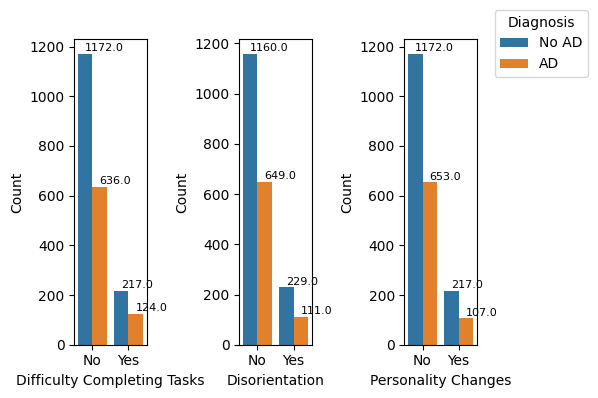

In [32]:
plt.figure(figsize=(6, 4))
plt.subplots_adjust(wspace=0.4)

plt.subplot(1, 3, 1)
ax1 = sns.countplot(x='DifficultyCompletingTasks', hue='Diagnosis', data=df, palette=custom_palette)
ax1.set_xticklabels(['No', 'Yes'])
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='left', va='center',
                xytext=(0, 4), 
                textcoords='offset points',
                fontsize=8)
plt.xlabel('Difficulty Completing Tasks')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
ax2 = sns.countplot(x='Disorientation', hue='Diagnosis', data=df, palette=custom_palette)
ax2.set_xticklabels(['No', 'Yes'])
for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='left', va='center',
                xytext=(0, 4), 
                textcoords='offset points',
                fontsize=8)
plt.xlabel('Disorientation')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
ax3 = sns.countplot(x='PersonalityChanges', hue='Diagnosis', data=df, palette=custom_palette)
ax3.set_xticklabels(['No', 'Yes'])
for p in ax3.patches:
    height = p.get_height()
    ax3.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='left', va='center',
                xytext=(0, 4), 
                textcoords='offset points',
                fontsize=8)
plt.xlabel('Personality Changes')
plt.ylabel('Count')

ax1.legend_.remove()
ax2.legend_.remove()
ax3.legend_.remove()

handles, labels = ax3.get_legend_handles_labels()
plt.figlegend(handles, ['No AD', 'AD'], loc='upper right', bbox_to_anchor=(1, 1), ncol=1, title='Diagnosis')

plt.tight_layout(rect=[0, 0, 0.85, 0.95])  
plt.savefig('/kaggle/working/Severe_Sub.png', dpi=600, bbox_inches='tight')
plt.show()


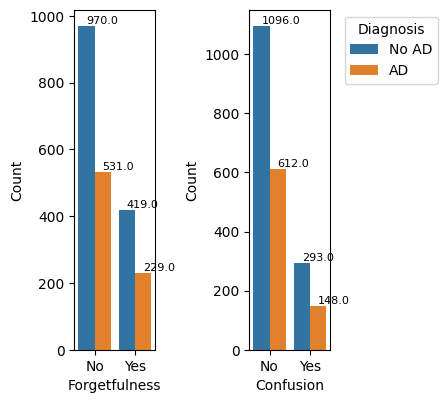

In [34]:
plt.figure(figsize=(6, 4))
# plt.subplots_adjust(wspace=0.4)

plt.subplot(1, 3, 1)
ax1 = sns.countplot(x='Forgetfulness', hue='Diagnosis', data=df, palette=custom_palette)
ax1.set_xticklabels(['No', 'Yes'])
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='left', va='center',
                xytext=(0, 4), 
                textcoords='offset points',
                fontsize=8)
plt.xlabel('Forgetfulness')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
ax2 = sns.countplot(x='Confusion', hue='Diagnosis', data=df, palette=custom_palette)
ax2.set_xticklabels(['No', 'Yes'])
for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='left', va='center',
                xytext=(0, 4), 
                textcoords='offset points',
                fontsize=8)
plt.xlabel('Confusion')
plt.ylabel('Count')

ax1.legend_.remove()
ax2.legend_.remove()

handles, labels = ax2.get_legend_handles_labels()
plt.figlegend(handles, ['No AD', 'AD'], loc='upper right', bbox_to_anchor=(0.75, 0.95), ncol=1, title='Diagnosis')

plt.tight_layout(rect=[0, 0, 0.85, 0.90])
plt.subplots_adjust(right=0.85, top=0.95, bottom=0.1, hspace=0.5)
plt.savefig('/kaggle/working/Lenient_Sub.png', dpi=600, bbox_inches='tight')
plt.show()


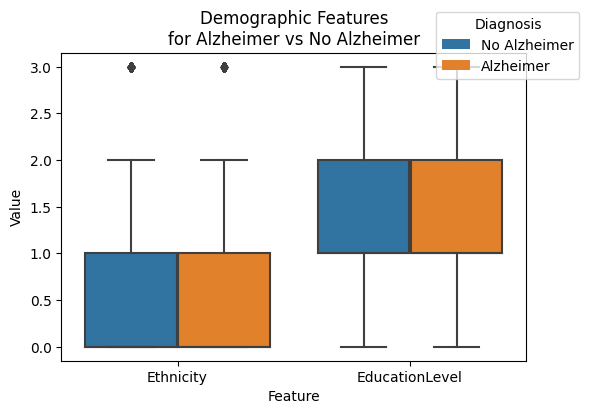

In [35]:
# Demographic features

df_melt = pd.melt(df, id_vars=['Diagnosis'], value_vars=['Ethnicity', 'EducationLevel'],
                  var_name='Feature', value_name='Value')

df_melt['Diagnosis'] = df_melt['Diagnosis'].map({1: 'Alzheimer', 0: 'No Alzheimer'})

plt.figure(figsize=(6, 4))
ax = sns.boxplot(x='Feature', y='Value', hue='Diagnosis', data=df_melt)
plt.title('Demographic Features\nfor Alzheimer vs No Alzheimer')
plt.xlabel('Feature')
plt.ylabel('Value')
ax.legend_.remove()
plt.figlegend(handles, ['No Alzheimer', 'Alzheimer'], loc='upper right', bbox_to_anchor=(1, 1), ncol=1, title='Diagnosis')
plt.savefig('/kaggle/working/DemographicFeatures_BoxPlot.png', dpi=600)
plt.show()


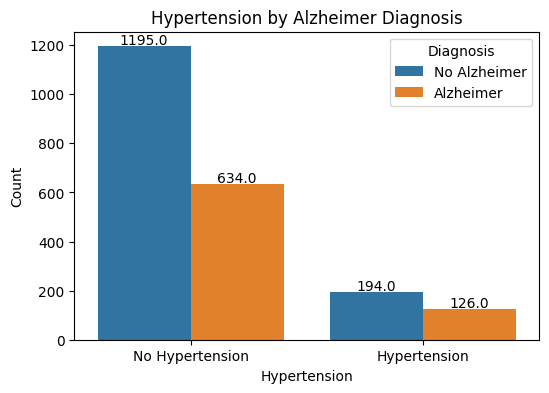

In [36]:
# Countplot based on Hypertension

plt.figure(figsize=(6, 4))
ax = sns.countplot(x='Hypertension', hue='Diagnosis', data=df, palette=custom_palette)
ax.set_xticklabels(['No Hypertension', 'Hypertension'])
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center',
                xytext=(0, 4), 
                textcoords='offset points')
plt.title('Hypertension by Alzheimer Diagnosis')
plt.xlabel('Hypertension')
plt.ylabel('Count')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['No Alzheimer', 'Alzheimer'], title='Diagnosis')
plt.savefig('Hypertension_CountPlot.png', dpi=600, bbox_inches='tight')
plt.show()


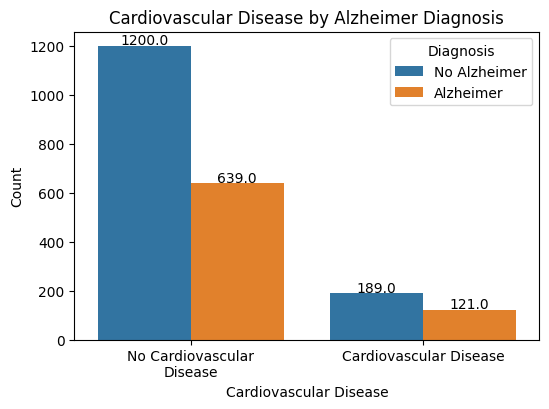

In [37]:
# Countplot based on CardiovascularDisease

plt.figure(figsize=(6, 4))
ax = sns.countplot(x='CardiovascularDisease', hue='Diagnosis', data=df, palette=custom_palette)
ax.set_xticklabels(['No Cardiovascular\nDisease', 'Cardiovascular Disease'])
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center',
                xytext=(0, 4), 
                textcoords='offset points')
plt.title('Cardiovascular Disease by Alzheimer Diagnosis')
plt.xlabel('Cardiovascular Disease')
plt.ylabel('Count')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['No Alzheimer', 'Alzheimer'], title='Diagnosis')
plt.savefig('/kaggle/working/CardiovascularDisease_CountPlot.png', dpi=600, bbox_inches='tight')
plt.show()


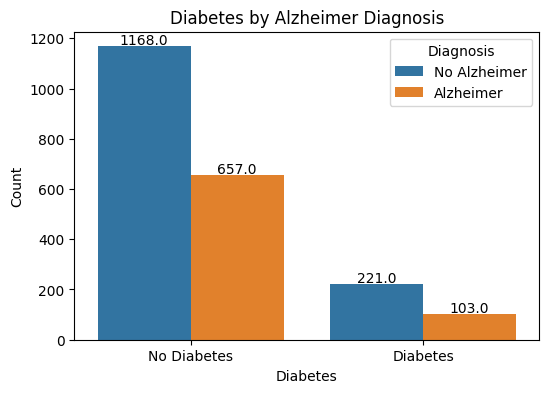

In [38]:
# Countplot based on Diabetes

plt.figure(figsize=(6, 4))
ax = sns.countplot(x='Diabetes', hue='Diagnosis', data=df, palette=custom_palette)
ax.set_xticklabels(['No Diabetes', 'Diabetes'])
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center',
                xytext=(0, 4), 
                textcoords='offset points')
plt.title('Diabetes by Alzheimer Diagnosis')
plt.xlabel('Diabetes')
plt.ylabel('Count')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['No Alzheimer', 'Alzheimer'], title='Diagnosis')
plt.savefig('Diabetes_CountPlot.png', dpi=600, bbox_inches='tight')
plt.show()


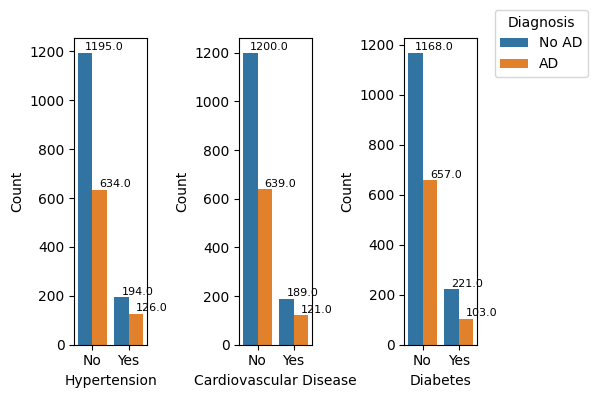

In [39]:
plt.figure(figsize=(6, 4))
plt.subplots_adjust(wspace=0.4)

plt.subplot(1, 3, 1)
ax1 = sns.countplot(x='Hypertension', hue='Diagnosis', data=df, palette=custom_palette)
ax1.set_xticklabels(['No', 'Yes'])
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='left', va='center',
                xytext=(0, 4), 
                textcoords='offset points',
                fontsize=8)
plt.xlabel('Hypertension')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
ax2 = sns.countplot(x='CardiovascularDisease', hue='Diagnosis', data=df, palette=custom_palette)
ax2.set_xticklabels(['No', 'Yes'])
for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='left', va='center',
                xytext=(0, 4), 
                textcoords='offset points',
                fontsize=8)
plt.xlabel('Cardiovascular Disease')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
ax3 = sns.countplot(x='Diabetes', hue='Diagnosis', data=df, palette=custom_palette)
ax3.set_xticklabels(['No', 'Yes'])
for p in ax3.patches:
    height = p.get_height()
    ax3.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='left', va='center',
                xytext=(0, 4), 
                textcoords='offset points',
                fontsize=8)
plt.xlabel('Diabetes')
plt.ylabel('Count')

ax1.legend_.remove()
ax2.legend_.remove()
ax3.legend_.remove()

handles, labels = ax3.get_legend_handles_labels()
plt.figlegend(handles, ['No AD', 'AD'], loc='upper right', bbox_to_anchor=(1, 1), ncol=1, title='Diagnosis')

plt.tight_layout(rect=[0, 0, 0.85, 0.95])  
plt.savefig('/kaggle/working/Health_Sub.png', dpi=600, bbox_inches='tight')
plt.show()


In [40]:
# EDA Before this

Accuracy: 0.95

Classification Report:
              precision    recall  f1-score   support

No Alzheimer       0.96      0.94      0.95       250
   Alzheimer       0.93      0.95      0.94       206

    accuracy                           0.95       456
   macro avg       0.94      0.95      0.94       456
weighted avg       0.95      0.95      0.95       456



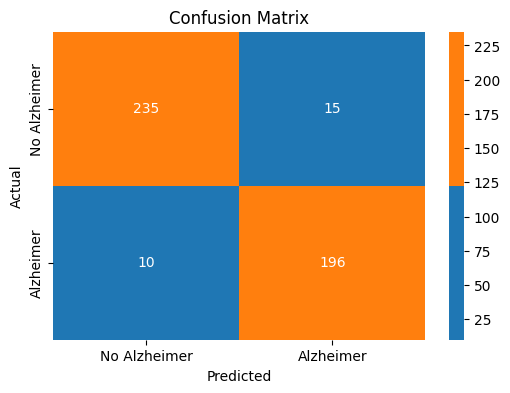

In [41]:
# Data Preprocessing 
label_encoder = LabelEncoder()
df['Gender'] = label_encoder.fit_transform(df['Gender'])
df['FamilyHistoryAlzheimers'] = label_encoder.fit_transform(df['FamilyHistoryAlzheimers'])
df['Diagnosis'] = label_encoder.fit_transform(df['Diagnosis'])

# col_norm = ['Age', 'Ethnicity', 'EducationLevel', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'ADL']

# # Min Max Scaling
# scaler = MinMaxScaler()
# df[col_norm] = scaler.fit_transform(df[col_norm])

# # Standard Scaling
# scaler = StandardScaler()
# df[col_norm] = scaler.fit_transform(df[col_norm])

# print('Normalized Data: ')
# print(df)

# X -> Features , y -> Target
X = df.drop(columns=['Diagnosis'])
y = df['Diagnosis']

X_balanced, y_balanced = balance_and_undersample(X, y)

# Changed
X = X_balanced
y = y_balanced

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Alzheimer', 'Alzheimer']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap=custom_palette, 
            xticklabels=['No Alzheimer', 'Alzheimer'], 
            yticklabels=['No Alzheimer', 'Alzheimer'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
plt.close()

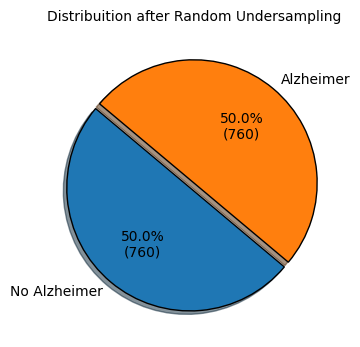

In [42]:
diagnosis_counts = pd.Series(y).value_counts()
labels = ['No Alzheimer', 'Alzheimer']

plt.figure(figsize=(4, 4))
plt.pie(diagnosis_counts, labels=labels, colors=custom_palette, 
        autopct=lambda p: f'{p:.1f}%\n({int(p * sum(diagnosis_counts) / 100):,})', 
        startangle=140, explode=[0.05, 0], shadow=True, 
        wedgeprops={'edgecolor': 'black'})
plt.title('Distribuition after Random Undersampling', fontsize=10)
plt.savefig('Balanced_Pie.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

**Models**

In [43]:
# Models

models = [
    (RandomForestClassifier(), 'RandomForestClassifier'),
    (GradientBoostingClassifier(), 'GradientBoostingClassifier'),
    (xgb.XGBClassifier(), 'XGBoostClassifier'),
    (AdaBoostClassifier(n_estimators=100), 'AdaBoostClassifier'),
    (HistGradientBoostingClassifier(), 'HistGradientBoostingClassifier')
]


In [44]:
# Feature selection
k = 5
selector = SelectKBest(score_func=f_classif, k=k)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

selected_feature_indices = selector.get_support(indices=True)
selected_features = X_train.columns[selected_feature_indices]
print(selected_features)

X_test = X_test_selected
X_train = X_train_selected

Index(['MMSE', 'FunctionalAssessment', 'MemoryComplaints',
       'BehavioralProblems', 'ADL'],
      dtype='object')


Model 1: RandomForestClassifier
Selected Features: 5
{'0.0': {'precision': 0.9558232931726908, 'recall': 0.952, 'f1-score': 0.9539078156312626, 'support': 250}, '1.0': {'precision': 0.9420289855072463, 'recall': 0.9466019417475728, 'f1-score': 0.9443099273607748, 'support': 206}, 'accuracy': 0.9495614035087719, 'macro avg': {'precision': 0.9489261393399686, 'recall': 0.9493009708737864, 'f1-score': 0.9491088714960187, 'support': 456}, 'weighted avg': {'precision': 0.9495916541834768, 'recall': 0.9495614035087719, 'f1-score': 0.9495719275090685, 'support': 456}}
Model 1: RandomForestClassifier
Selected Features: 5
{'0.0': {'precision': 0.956, 'recall': 0.956, 'f1-score': 0.956, 'support': 250}, '1.0': {'precision': 0.9466019417475728, 'recall': 0.9466019417475728, 'f1-score': 0.9466019417475728, 'support': 206}, 'accuracy': 0.9517543859649122, 'macro avg': {'precision': 0.9513009708737864, 'recall': 0.9513009708737864, 'f1-score': 0.9513009708737864, 'support': 456}, 'weighted avg': {'p

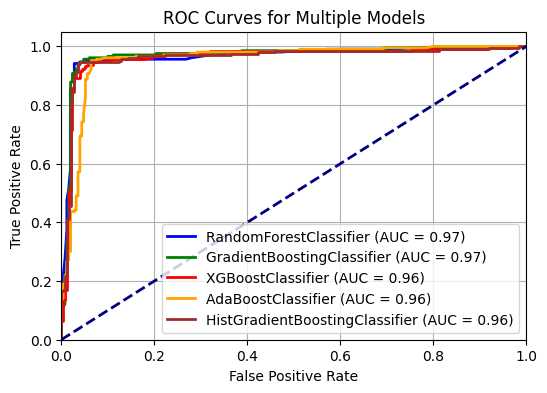

ROC plot saved at /kaggle/working/combined_roc_curves.png
Metrics: (w/o selection )
                            Model  Training Accuracy  Testing Accuracy  \
0          RandomForestClassifier           1.000000          0.949561   
1      GradientBoostingClassifier           0.956767          0.951754   
2               XGBoostClassifier           1.000000          0.932018   
3              AdaBoostClassifier           0.922932          0.916667   
4  HistGradientBoostingClassifier           0.999060          0.940789   

   Precision    Recall  Specificity  F1 Score       AUC  Log Loss   Jaccard  \
0   0.949592  0.949561        0.952  0.949572  0.965058  0.346954  0.894495   
1   0.951976  0.951754        0.948  0.951792  0.968689  0.215137  0.899543   
2   0.932953  0.932018        0.920  0.932121  0.962796  0.252167  0.862832   
3   0.921322  0.916667        0.880  0.916861  0.955544  0.679235  0.838983   
4   0.941129  0.940789        0.936  0.940845  0.962408  0.234035  0.878378 

In [45]:
met = pd.DataFrame()
met_k_best = pd.DataFrame()

idx = 1
basic_colors = ['blue', 'green', 'red', 'orange', 'brown']
roc_auc_values = []
plt.figure(figsize=(6, 4))
for (model, model_name), color in zip(models, basic_colors):
    metrics = compute_metrics(model, X_train, X_test, y_train, y_test, model_name, idx)
    metrics_k_best = compute_metrics(model, X_train, X_test, y_train, y_test, model_name, idx, k=5)
    
    met_k_best = pd.concat([met_k_best, metrics_k_best], ignore_index=True)
    met = pd.concat([met, metrics], ignore_index=True)
    
    idx += 1
    
    y_test_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    roc_auc = auc(fpr, tpr)
    
    roc_auc_values.append((model_name, roc_auc))
    
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiple Models')
plt.legend(loc="lower right")
plt.grid(True)

roc_plot_path = '/kaggle/working/combined_roc_curves.png'
plt.savefig(roc_plot_path, dpi=600)
plt.show()

print(f'ROC plot saved at {roc_plot_path}')

metrics_path = '/kaggle/working/'
csv_name = 'alz_metrics.csv'
met.to_csv(metrics_path + csv_name, index=False)
met_k_best.to_csv(metrics_path + 'alz_k_best.csv', index=False)
print('Metrics: (w/o selection )')
print(met)


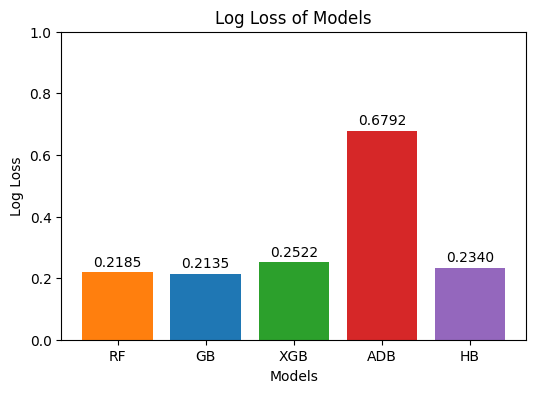

In [46]:
# Log loss
models = [
    (RandomForestClassifier(), 'RF'),
    (GradientBoostingClassifier(), 'GB'),
    (xgb.XGBClassifier(), 'XGB'),
    (AdaBoostClassifier(n_estimators=100), 'ADB'),
    (HistGradientBoostingClassifier(), 'HB')
]

log_losses = []

for model, name in models:
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)
    log_loss_value = log_loss(y_test, y_pred_proba)
    log_losses.append((name, log_loss_value))

colors = ['#ff7f0e', '#1f77b4', '#2ca02c', '#d62728', '#9467bd']
plt.figure(figsize=(6, 4))
plt.tight_layout()

for i, (name, log_loss_value) in enumerate(log_losses):
    plt.bar(name, log_loss_value, color=colors[i])
    plt.text(i, log_loss_value + 0.02, f'{log_loss_value:.4f}', ha='center')

plt.ylim(0, 1)
plt.title('Log Loss of Models')
plt.xlabel('Models')
plt.ylabel('Log Loss')

plt.savefig('log_loss_models.png', dpi=600)
plt.show()

Predicted Class: No Alzheimer
Prediction Probabilities: No Alzheimer: 0.98, Alzheimer: 0.02
Actual Class: No Alzheimer


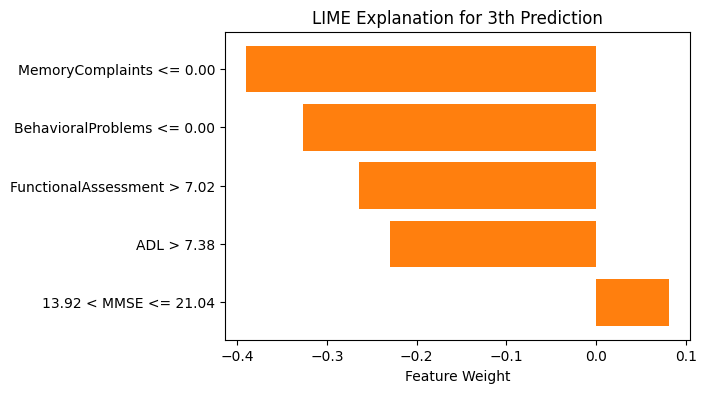

In [47]:
import numpy as np
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif

model = GradientBoostingClassifier()
model.fit(X_train_selected, y_train)

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_selected),
    feature_names=selected_features,
    class_names=['No Alzheimer', 'Alzheimer'],
    mode='classification'
)

i = 3
sample = np.array(X_test_selected[i])
predicted_class = model.predict([sample])[0]
predicted_proba = model.predict_proba([sample])[0]
true_label = y_test[i]

print(f"Predicted Class: {'Alzheimer' if predicted_class == 1 else 'No Alzheimer'}")
print(f"Prediction Probabilities: No Alzheimer: {predicted_proba[0]:.2f}, Alzheimer: {predicted_proba[1]:.2f}")
print(f"Actual Class: {'Alzheimer' if true_label == 1 else 'No Alzheimer'}")
# S

explanation = explainer.explain_instance(
    data_row=sample,
    predict_fn=model.predict_proba
)

exp = explanation.as_list()

features, weights = zip(*exp)

plt.figure(figsize=(6, 4))
plt.barh(features, weights, color=ORANGE)
plt.xlabel('Feature Weight')
plt.title(f'LIME Explanation for {i}th Prediction')
plt.gca().invert_yaxis() 

plt.savefig('lime_explanation_plot.png', dpi=600, bbox_inches='tight')
plt.show()

explanation.save_to_file('lime_explanation.html')


In [48]:
import matplotlib
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

matplotlib.use('Agg')

X_test_df = pd.DataFrame(X_test, columns=selected_features)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_df)

print(X_test_df.shape)
print('Expected Value: ', explainer.expected_value)

plt.clf()
plt.figure(figsize=(15, 6))
shap.summary_plot(shap_values, X_test_df, plot_type="bar", color=ORANGE)

fig = plt.gcf()
plt.draw()
image = np.array(fig.canvas.renderer.buffer_rgba())

cv2.imwrite('/kaggle/working/shap_summary_plot.jpg', cv2.cvtColor(image, cv2.COLOR_RGBA2BGR))

plt.close(fig)


(456, 5)
Expected Value:  [0.3497792]


In [49]:
print(selected_features)
print(type(selected_features[-1]))

Index(['MMSE', 'FunctionalAssessment', 'MemoryComplaints',
       'BehavioralProblems', 'ADL'],
      dtype='object')
<class 'str'>


In [56]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

matplotlib.use('Agg')

def compute_ale(model, X, feature_name, n_bins=20):
    feature_idx = X.columns.get_loc(feature_name)
    X_sorted = X.sort_values(by=feature_name)
    bin_edges = np.linspace(X_sorted[feature_name].min(), X_sorted[feature_name].max(), n_bins + 1)
    bin_means = []
    for i in range(n_bins):
        bin_mask = (X_sorted[feature_name] >= bin_edges[i]) & (X_sorted[feature_name] < bin_edges[i + 1])
        if bin_mask.sum() > 0:
            bin_mean = model.predict_proba(X_sorted[bin_mask])[:, 1].mean()
            bin_means.append(bin_mean)
        else:
            bin_means.append(np.nan)
    return bin_edges, bin_means

X_test_df = pd.DataFrame(X_test, columns=selected_features)
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

for feature in selected_features:
    bin_edges, bin_means = compute_ale(model, X_test_df, feature)
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(bin_edges[:-1], bin_means, marker='o')
    ax.set_title(f'ALE Plot for {feature}', fontsize=30)
    ax.set_xlabel(feature, fontsize=20)
    ax.set_ylabel('Mean Predicted Probability', fontsize=20)
    plt.tight_layout()
    
    plt.draw()
    image = np.array(fig.canvas.renderer.buffer_rgba())
    
    if np.all(image[:, :, :3] == 255):  # Check if the image is blank white
        print(f"Warning: ALE plot for {feature} is blank.")
    else:
        cv2.imwrite(f'/kaggle/working/ale_plot_{feature}.jpg', cv2.cvtColor(image, cv2.COLOR_RGBA2BGR))
    
    plt.close(fig)

X has feature names, but GradientBoostingClassifier was fitted without feature names
X has feature names, but GradientBoostingClassifier was fitted without feature names
X has feature names, but GradientBoostingClassifier was fitted without feature names
X has feature names, but GradientBoostingClassifier was fitted without feature names
X has feature names, but GradientBoostingClassifier was fitted without feature names
X has feature names, but GradientBoostingClassifier was fitted without feature names
X has feature names, but GradientBoostingClassifier was fitted without feature names
X has feature names, but GradientBoostingClassifier was fitted without feature names
X has feature names, but GradientBoostingClassifier was fitted without feature names
X has feature names, but GradientBoostingClassifier was fitted without feature names
X has feature names, but GradientBoostingClassifier was fitted without feature names
X has feature names, but GradientBoostingClassifier was fitted wi

In [51]:
import eli5

In [52]:
eli5.explain_weights(model, feature_names=list(['MMSE', 'FunctionalAssessment', 'MemoryComplaints',
       'BehavioralProblems', 'ADL']))

Weight,Feature
0.2432 ± 0.3390,FunctionalAssessment
0.2380 ± 0.3511,MMSE
0.2369 ± 0.4302,ADL
0.1587 ± 0.1742,MemoryComplaints
0.1232 ± 0.1544,BehavioralProblems


In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
import xgboost as xgb
from sklearn.datasets import make_classification
import time

colors = ['#ff7f0e', '#1f77b4', '#2ca02c', '#d62728', '#9467bd']
models = [
    (RandomForestClassifier(), 'RF'),
    (GradientBoostingClassifier(), 'GB'),
    (xgb.XGBClassifier(), 'XGB'),
    (AdaBoostClassifier(n_estimators=100), 'ADB'),
    (HistGradientBoostingClassifier(), 'HB')
]

sizes = [100, 500, 1000, 2000, 5000, 10000]  # Different sizes of datasets
times = {model_name: [] for _, model_name in models}

for size in sizes:
    X, y = make_classification(n_samples=size, n_features=20, random_state=42)
    
    for model, model_name in models:
        start_time = time.time()
        model.fit(X, y)
        elapsed_time = time.time() - start_time
        times[model_name].append(elapsed_time)
i = 0
for model_name in times:
    plt.plot(sizes, times[model_name], label=model_name, marker='o', color=colors[i])
    i += 1

plt.title('Time Complexity of Classifiers')
plt.xlabel('Number of Samples (linear scale)')
plt.ylabel('Time (seconds) (linear scale)')
plt.legend()
plt.xscale('linear')
plt.yscale('linear')
plt.grid()
plt.savefig('TimeComplexity.png', dpi=600, bbox_inches='tight')
plt.show()
